In [1]:
from dottamine import dotim
import numpy as np
import skimage as sk
# import napari
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
import networkx as nx


In [2]:
mask = sk.io.imread('domes/70_denoised_mask.tif').astype(np.uint8)
image = sk.io.imread('domes/70_denoised.tif')
image = np.transpose(image[3], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

In [3]:
print(mask.shape)
print(image.shape)

(858, 550, 858)
(858, 550, 858)


In [4]:
closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

closed_mask = np.array(closed_mask)
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1

    

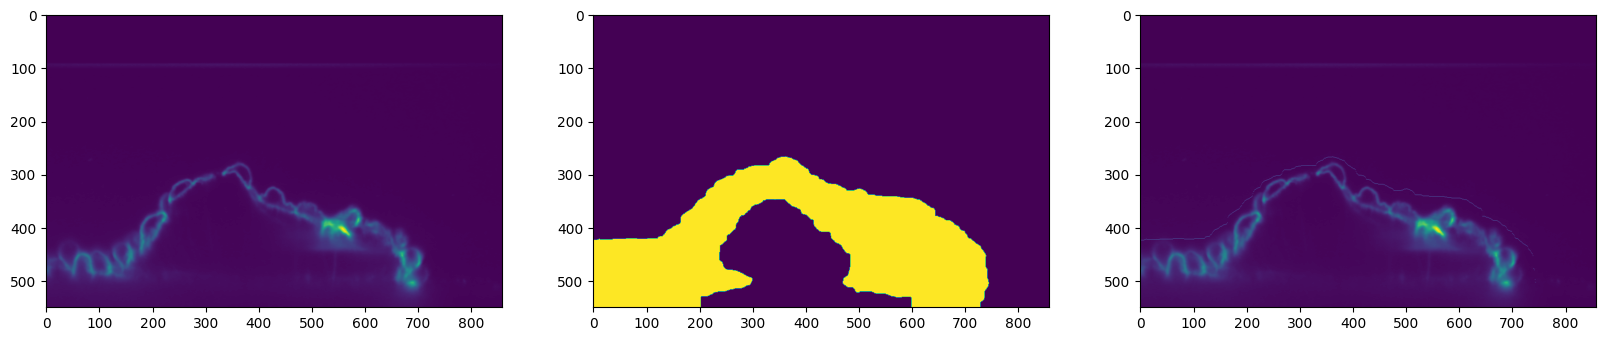

In [220]:
y = 300
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image[y])
plt.subplot(132)
plt.imshow(closed_mask[y])
plt.subplot(133)
plt.imshow(top_mask[y]*300+image[y])

In [109]:
def smooth_array(arr, window_size):
    kernel = np.ones(window_size) / window_size
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    return smoothed_arr

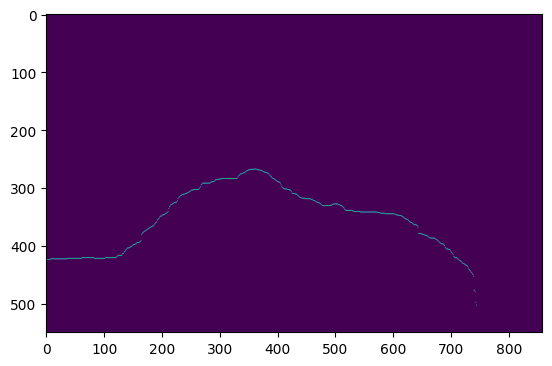

In [110]:
plt.imshow(top_mask[y])

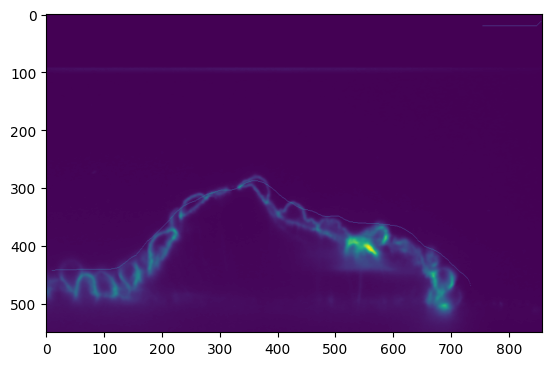

In [225]:
height = []

for i in range(top_mask[y].shape[1]):
    col = top_mask[y][:, i]
    height.append(np.where(col == 1)[0][0]+20) # Add a value to move the line

height = np.array(height)
x = np.linspace(0, 1, i+1)

window_size = 20
height = smooth_array(height, window_size)

height_matrix = np.zeros((top_mask[y].shape))

height_smooth = []
height_smooth.append(-1)

for i in range(height_matrix.shape[1]-1):
    if abs(height[i]-height[i+1]) < 10: # Check the absolute difference value!
        if height[i] == 0 and height[i-1] == 0:
            height_smooth.append(-1)
            continue
        height_matrix[int(height[i])][i] = 1
        height_smooth.append(height[i])
    else:
        height_smooth.append(-1)

plt.imshow(height_matrix*300+image[y])


In [226]:
# Find the normal vector at each point of the curve so we can find brightest intensities.

x_vector = np.linspace(1, len(height_smooth), len(height_smooth))
derivative = np.gradient(height_smooth) # If derivative is 0, that means the normal is completely vertical.
# So the m of the perpendicular vector to the derivative must be 1/derivative. 
normals = ['inf' if i == 0 else -1/i for i in derivative]
n_normals = [] # This vector contains the n if the normal of the derivative is not an 'inf' or the n if the normal is a line.

for m_normal, y_smooth, x_value in zip(normals, height_smooth, x_vector):
    if m_normal == 'inf':
        n_normals.append(x_value)
    else:
        n_normals.append(y_smooth-m_normal*x_value)

print(n_normals)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, -0.9504839072698628, 443.3540236353404, 183.25000000005906, 163.19999999990443, 143.1500000000682, 123.10000000007267, 103.049999999884, 83.0000000000818, 62.94999999987033, -357.1000000007276, 21.0, 22.0, 1362.9000000008368, 922.9500000001636, 1442.9999999997726, 26.0, 27.0, 28.0, -717.000000001055, -157.0500000005457, -177.10000000056385, -197.150000000582, -217.20000000022497, -237.2500000002318, -257.3000000002386, -277.34999999983614, -297.3999999998316, -317.44999999982707, -337.49999999982253, -357.549999999818, -377.6000000002796, -397.65000000028635, -417.69999999980433, -437.7499999997998, -457.79999999979526, -477.8500000003137, -497.90000000032046, -517.9499999997815, -1517.9999999995543, 50.0, 51.0, 52.0, 53.0, -1717.9999999995089, -658.0499999997498, -678.0999999997453, -698.1499999997407, -718.1999999997362, -738.2499999997317, -758.3000000004092, -778.350000000416, -798.3999999997179, -818.4499999997134, -838.499999999

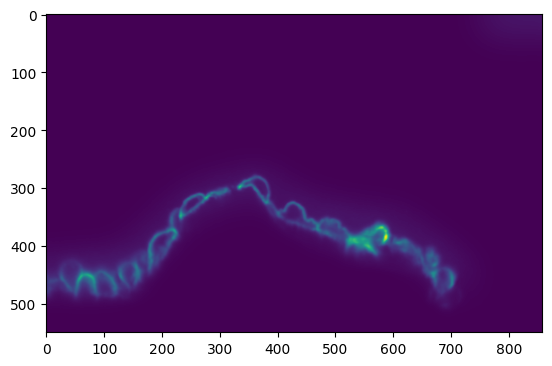

In [227]:
height_mask = cv2.GaussianBlur(height_matrix, (199, 199), 0)*image[y]

plt.imshow(height_mask)
# np.argmax(closed_mask != 0, axis=1)

cell_border = []

for i in range(height_mask.shape[1]):
    col = height_mask[:, i]
    cell_border.append(np.argmax(col == max(col)))


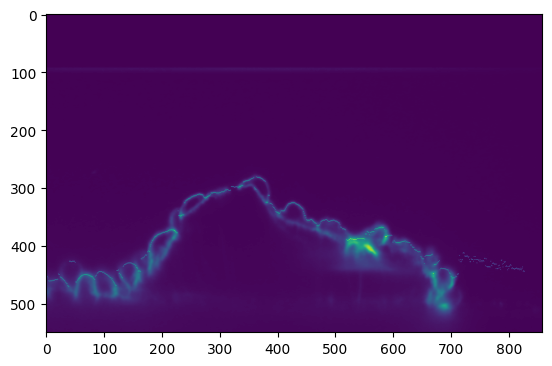

In [213]:
cell_top_mask = np.zeros_like(height_mask)
for i in range(cell_top_mask.shape[1]):
    cell_top_mask[cell_border[i], i] = 1


plt.imshow(cell_top_mask*600+image[y])

# Get 3D top 